In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
%matplotlib inline

In [2]:
clustered_masks_path = '/home/wences/Documents/GitRepos/SlidingWindowsBudDetection/output/result300_150step/clustered_masks/'
prediction_masks_path = '/home/wences/Documents/GitRepos/SlidingWindowsBudDetection/output/result300_150step/binary_masks/'
source_images_path = '/home/wences/Documents/corpus-26000/images/'

In [19]:
per_sample_csv = pd.read_csv('metrics_cluster_result300_150step.csv')
ground_truth = pd.read_csv('single_instance_dataset_wradius.csv')
test_set_image_list = pd.read_csv('single_instance_test.csv')
test_set_image_list = test_set_image_list['imageOrigin'].values
ground_truth_test = ground_truth.loc[ground_truth['imageOrigin'].isin(test_set_image_list.tolist()), :]

### Breve descripcion de las distancias obtenidas a traves de todos los thresholds

In [21]:
per_sample_csv['true_positive_distance'].describe()

count     139.000000
mean      357.771088
std       489.935309
min        23.759209
25%       113.455633
50%       181.648776
75%       286.402490
max      2096.219496
Name: true_positive_distance, dtype: float64

### Promedio y desviacion estandard de a cada threshold

In [22]:
per_sample_csv['true_positive_distance'].std()

489.9353088379876

In [23]:
per_sample_csv['true_positive_distance'].mean()

357.7710881931591

### Ahora dividamos los resultados en rangos de distancia y veamos cuantos centros de yema caen en cada bolsa. (Veamos que tan dispersas son las predicciones del modelo en cuanto a distancia normalizada)

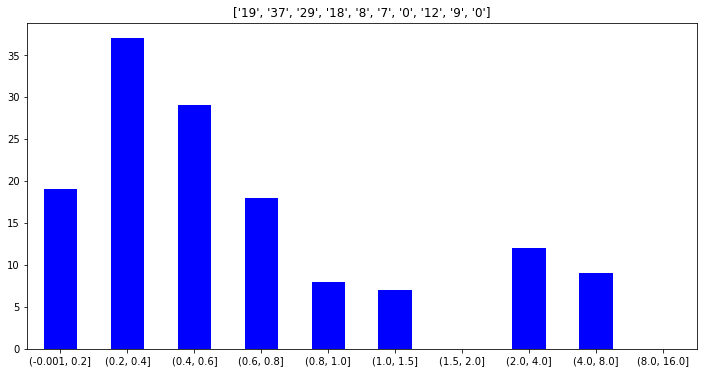

In [24]:
out = pd.cut(per_sample_csv['true_positive_norm_distance'].values, bins=[0,0.2,0.4,0.6,0.8,1,1.5,2,4,8,16], include_lowest=True)
out.value_counts().plot.bar(rot=0, color="b", figsize=(12,6))
plt.title([str(out.value_counts().values[i]) for i in range(out.value_counts().values.shape[0])]);

### Ahora dividamos los resultados en rangos de distancia y veamos cuantos centros de yema caen en cada bolsa. (Veamos que tan dispersas son las predicciones del modelo en cuanto a distancia normalizada)

### Numero de NaNs en el conjunto de testeo, no yema detectada, imagen negra

In [25]:
per_sample_csv.loc[per_sample_csv['buds_predicted'] == 0,:].shape[0]

1

### Numero de clusteres detectados en las mascaras generada

In [26]:
per_sample_csv['buds_predicted'].sum() #140 yemas son las que contiene el test set

423

### Visualizacion de 10 imagenes donde no se pudieron detectar yemas

In [27]:
w=10
h=10
columns = 4
rows = 5

In [28]:
temp = per_sample_csv.loc[per_sample_csv['buds_predicted'] == 0,:]
img_list = temp['mask_name'].values

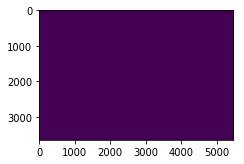

In [29]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, img_list.shape[0]):
    img = cv2.imread(os.path.join(prediction_masks_path,img_list[i]), 0)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

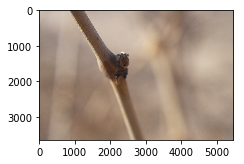

In [30]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, img_list.shape[0]):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][12:])), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

### Veamos las escenas donde se detecto solo una yema

In [31]:
temp = per_sample_csv.loc[per_sample_csv['buds_predicted'] == 1,:]
img_list = temp['mask_name'].values

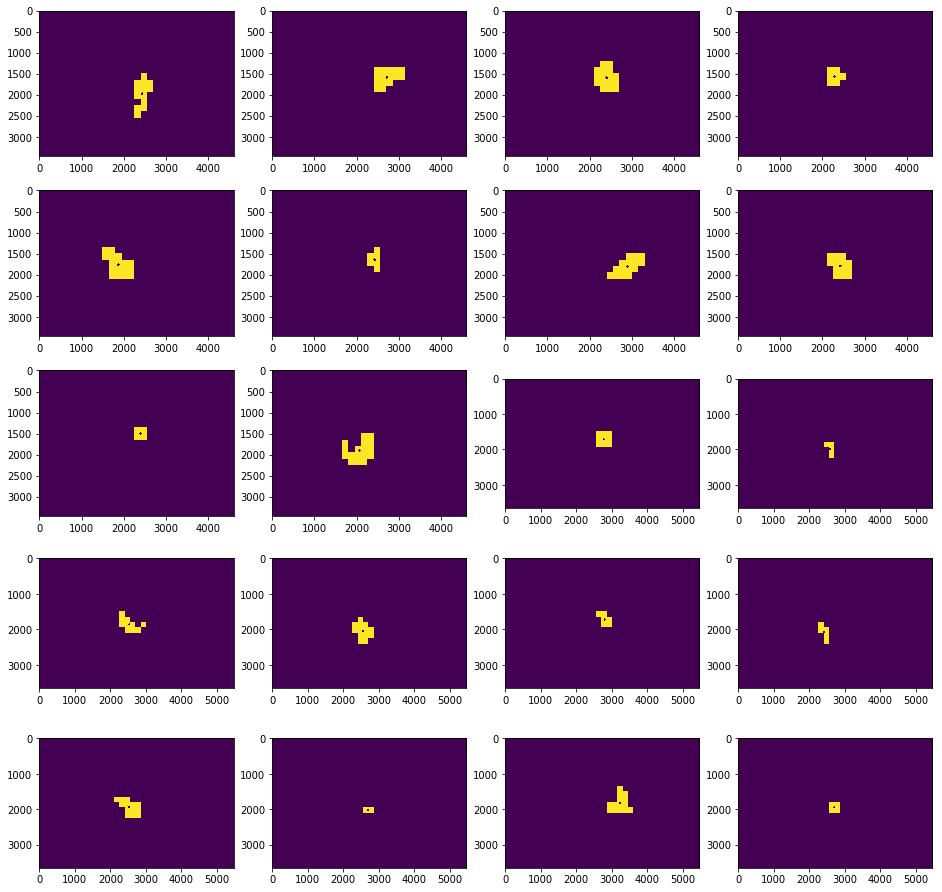

In [32]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = cv2.imread(os.path.join(prediction_masks_path,img_list[i]),0)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cv2.circle(img, center=center, radius=30, color=(0,0,0),thickness=-1))
plt.show()

Distancia en pixeles respecto de los centros gt y de su true positive, arriba de cada imagen 

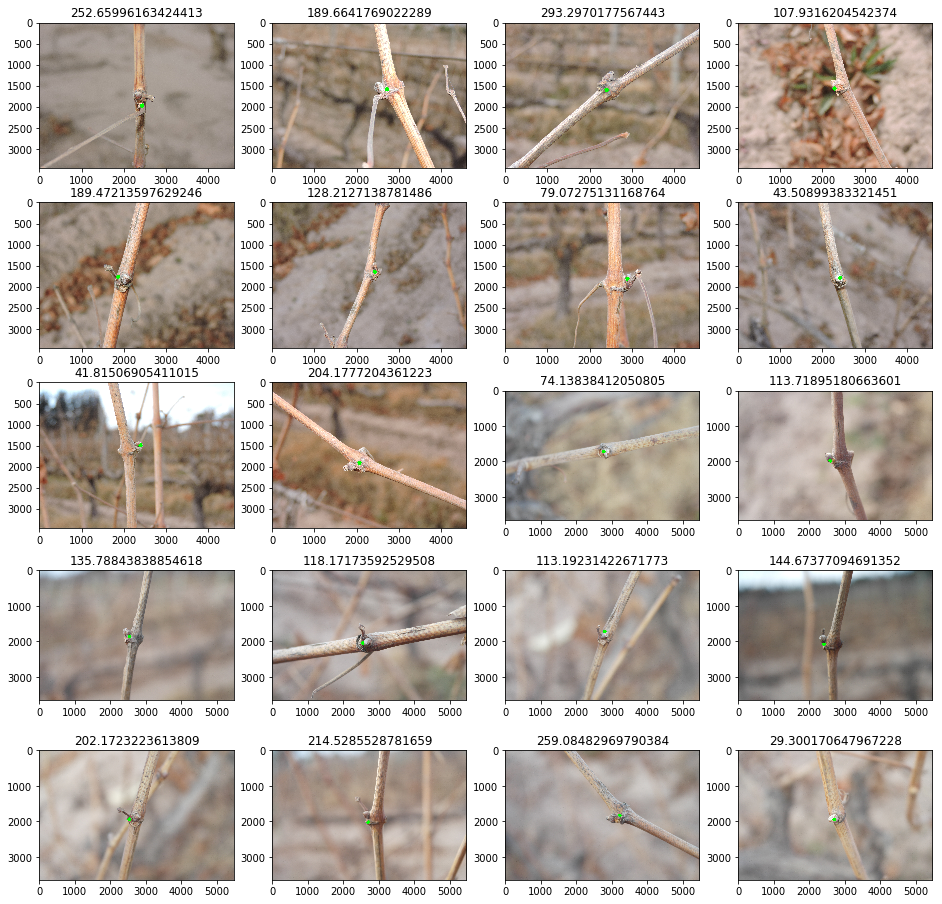

In [33]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][12:])), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=center, radius=50, color=(0,255,0),thickness=-1))
plt.show()

### Veamos aquellas instancias sobre las que se detectaron varios clusters

In [34]:
temp = per_sample_csv.loc[(per_sample_csv['buds_predicted'] >= 2),:]
img_list = temp['mask_name'].values

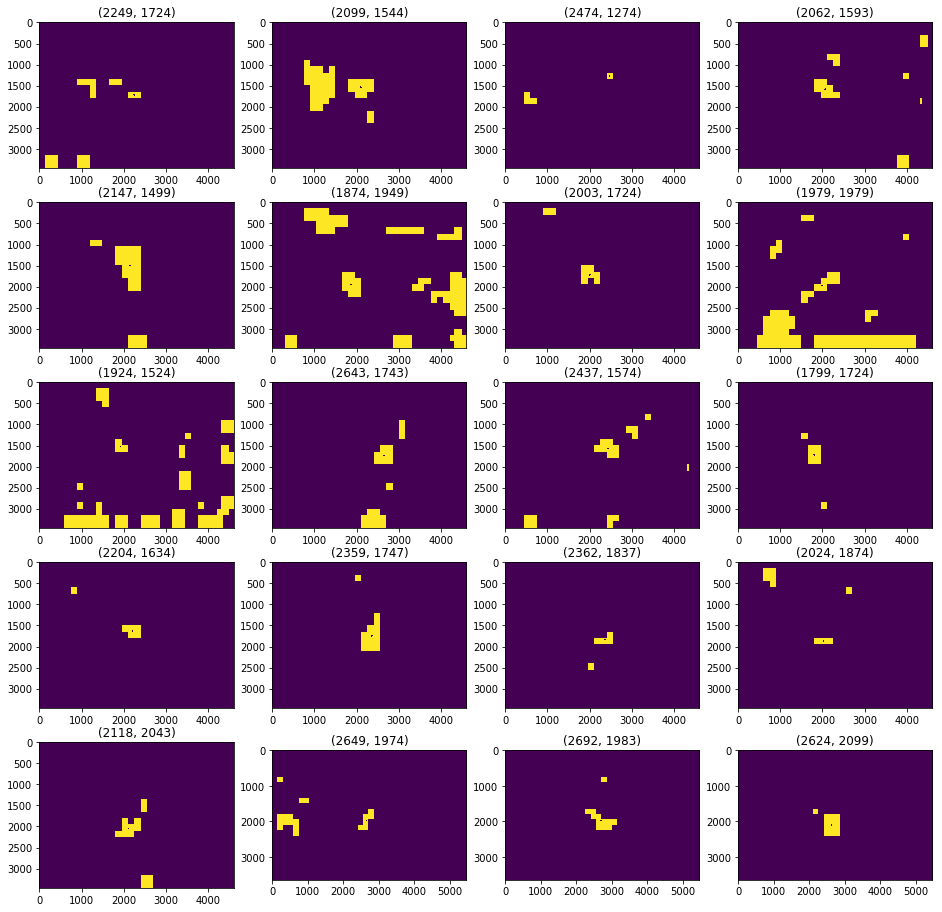

In [35]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.imread(os.path.join(prediction_masks_path,img_list[i]),0)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=center)
    plt.imshow(cv2.circle(img, center=center, radius=20, color=(0,0,0),thickness=-1))
plt.show()

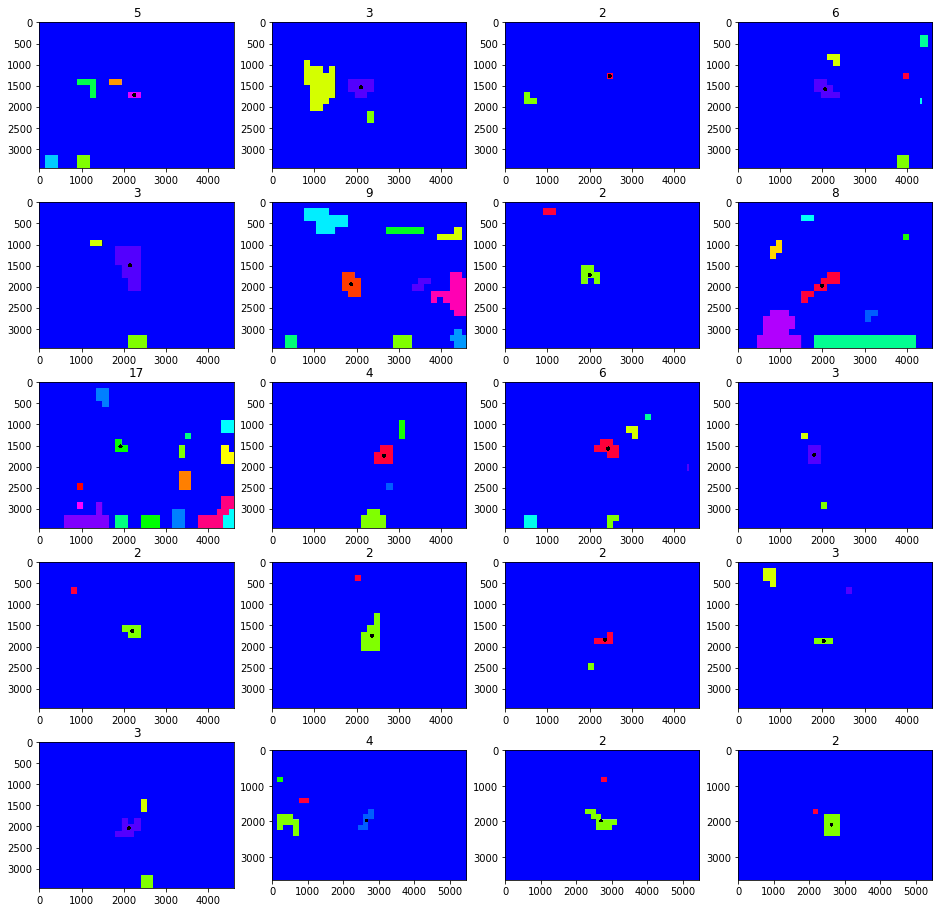

In [36]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(clustered_masks_path,'cluster_'+img_list[i])), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=50, color=(0,0,0),thickness=-1))
plt.show()

## Comentario: 
A diferencia de la aplicacion exitosa de dbscan para 'limpiar' los outliers y definir un cluster para puntos en el espacio (keypoints) correspondientes a las nubes de puntos generadas por ORBSLAM, en nuestro caso cuando tenemos al menos un keypoint clasificado como positivo este se refleja en la mascara resultante, no como un punto sino como un patch de 300x300 positivo, el cual dbscan en vez de descartarlo como outlier lo toma como un cluster en si. Es por eso que se obtienen un monton de clusters 'espurios'.


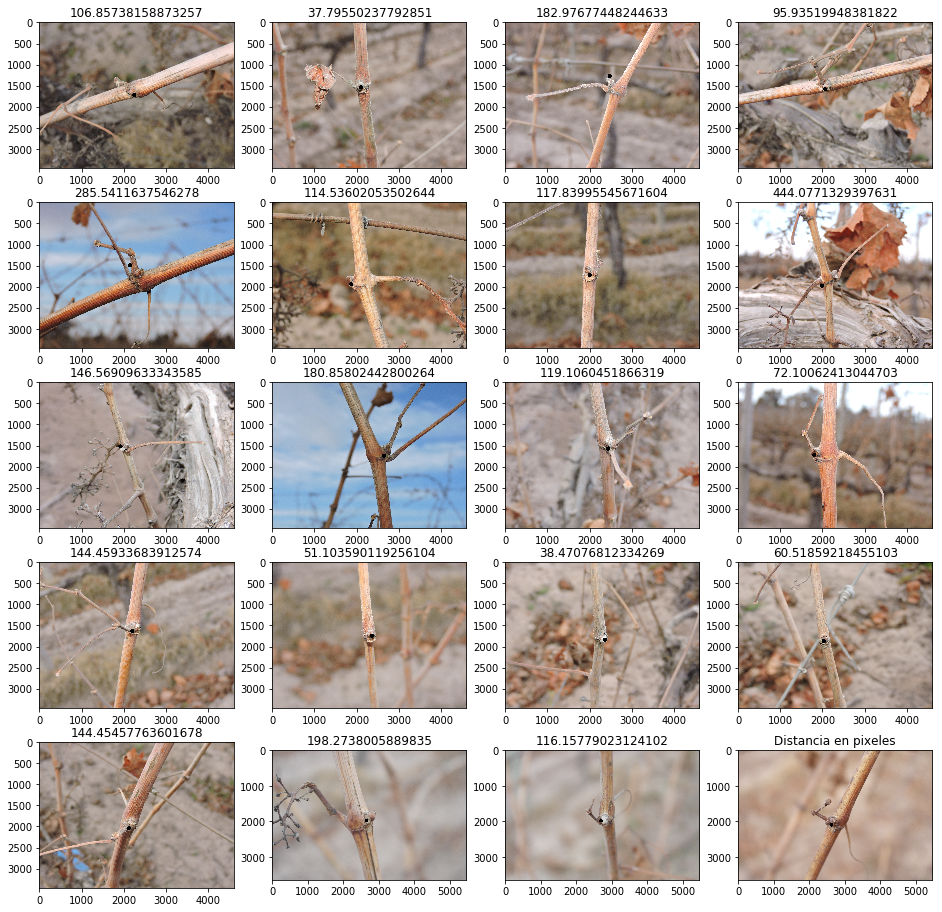

In [37]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][12:])), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_distance'])
    plt.imshow(cv2.circle(img, center=center, radius=50, color=(0,0,0),thickness=-1))
plt.title('Distancia en pixeles')
plt.show()

### Veamos los casos en los que la distancia euclideana normalizada fue mayor a un diametro de yema

In [38]:
temp = per_sample_csv.loc[(per_sample_csv['true_positive_norm_distance'] >= 1),:]
img_list = temp['mask_name'].values
print("Predicciones donde la distancia a ground truth normalizada fue mayor a 1 diametro de yema: "+str(temp.shape[0]))

Predicciones donde la distancia a ground truth normalizada fue mayor a 1 diametro de yema: 28


In [39]:
w=10
h=10
columns = 4
rows = 4

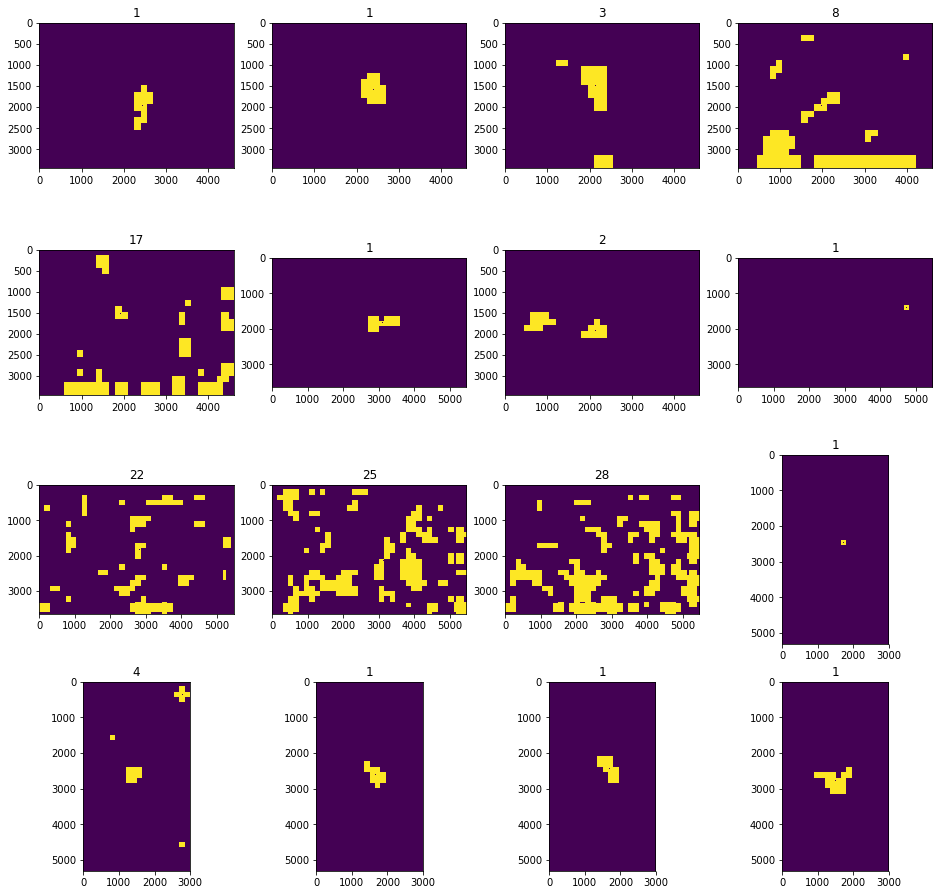

In [40]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = cv2.imread(os.path.join(prediction_masks_path,img_list[i]),0)
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=15, color=(0,0,0),thickness=-1))
plt.show()


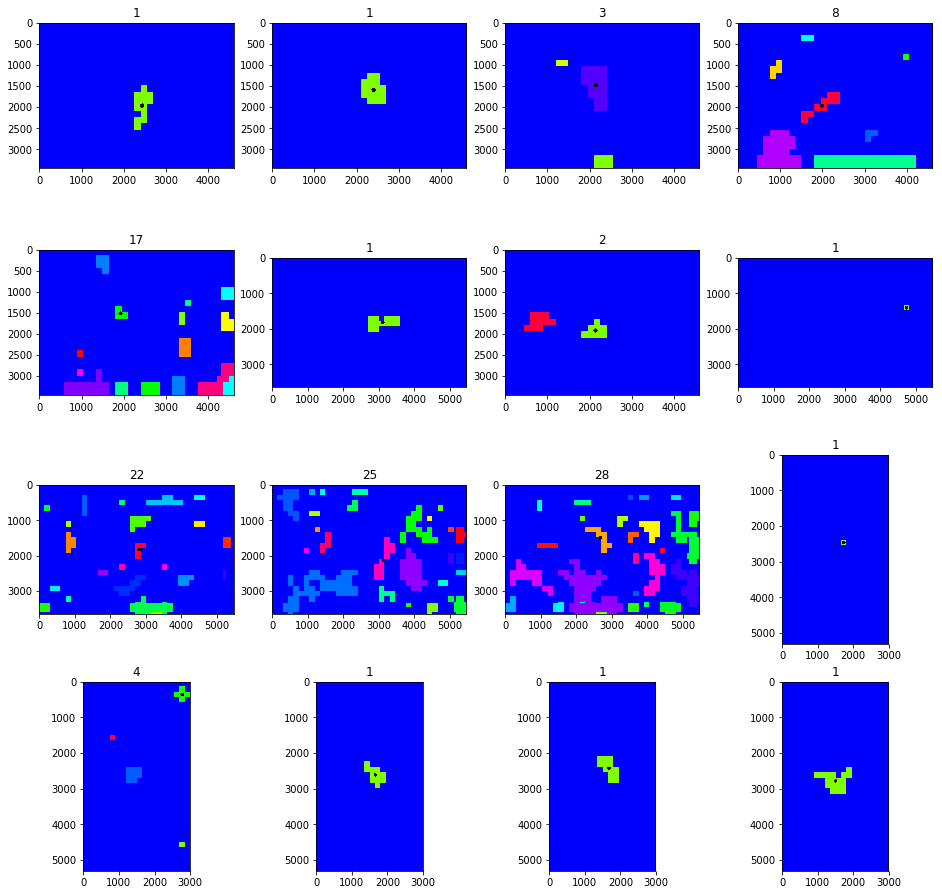

In [41]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    img = cv2.cvtColor(cv2.imread(os.path.join(clustered_masks_path,'cluster_'+img_list[i])), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['buds_predicted'])
    plt.imshow(cv2.circle(img, center=center, radius=50, color=(0,0,0),thickness=-1))
plt.show()

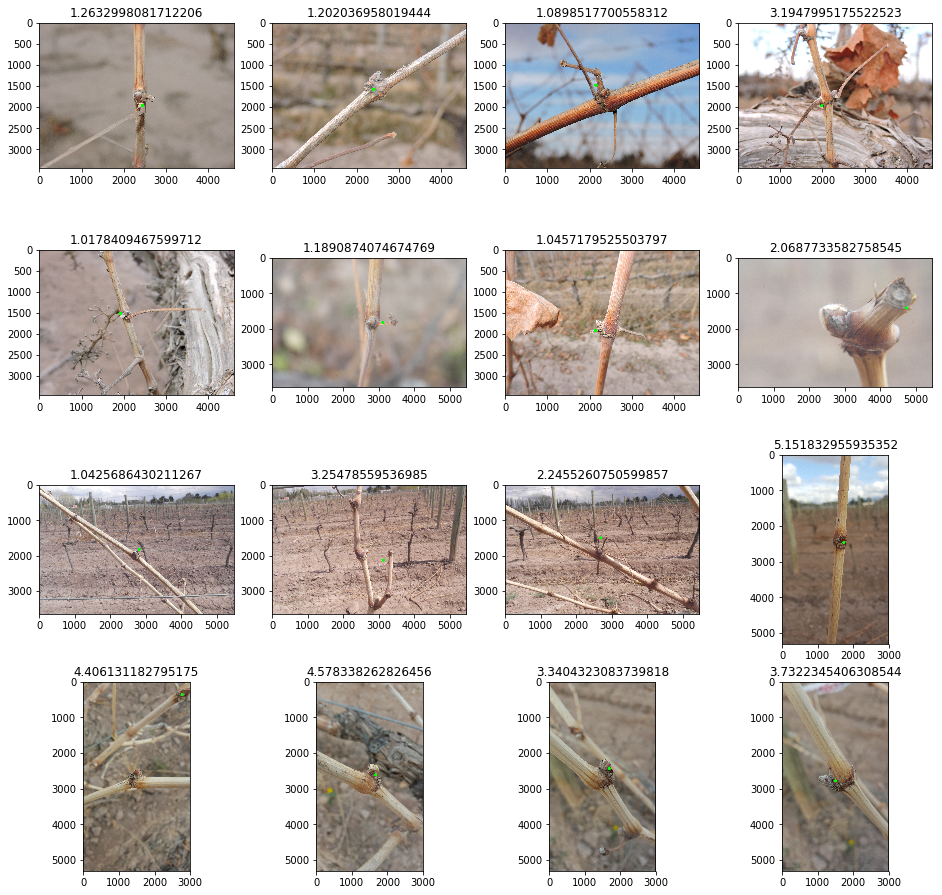

In [42]:
fig=plt.figure(figsize=(16, 16))
for i in range(0, columns*rows):
    img = cv2.cvtColor(cv2.imread(os.path.join(source_images_path, img_list[i][12:])), cv2.COLOR_BGR2RGB)
    center = (int(temp.iloc[i,:]['true_positive_x']), int(temp.iloc[i,:]['true_positive_y']))
    fig.add_subplot(rows, columns, i+1, title=temp.iloc[i,:]['true_positive_norm_distance'])
    plt.imshow(cv2.circle(img, center=center, radius=40, color=(0,255,0),thickness=-1))
plt.show()

### Resultado Precision y Recall  
-  Fijarse de que haya un threshold para true positives en distancia para que no queden clusters malisimos como tp


In [43]:
true_positives = per_sample_csv.loc[per_sample_csv['buds_predicted']>=1,:].shape[0]
false_positives = per_sample_csv['buds_predicted'].sum() - per_sample_csv.loc[per_sample_csv['buds_predicted']>0,:].shape[0]
precision = (true_positives / (true_positives + false_positives))
print('Precision: ' + str(precision))

Precision: 0.32860520094562645


In [44]:
true_positives = per_sample_csv.loc[per_sample_csv['buds_predicted']>=1,:].shape[0]
false_negatives = per_sample_csv.loc[per_sample_csv['buds_predicted']==0,:].shape[0] # aquellos en los que no se predijeron ninguna
recall = (true_positives / (true_positives + false_negatives))
print('Recall: ' + str(recall))

Recall: 0.9928571428571429
